In [37]:
# Importar librerias
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Lectura de datos

In [2]:
data_train = pd.read_csv('./data/housing_train.csv', sep=',')
data_test = pd.read_csv('./data/housing_test.csv', sep=',')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Preprocesamiento de los datos

## Revisar registros duplicados exactos

In [4]:
# Analisis de registros duplicados exactos
print('Número de duplicados:', data_train.duplicated().sum())

Número de duplicados: 0


## Corrección del tipo de datos

In [5]:
# Corregir el tipo de dato de las columnas
for col in data_train.columns:
    if data_train[col].dtype == 'object':
        data_train[col] = data_train[col].astype('category')
    else:
        data_train[col] = data_train[col].astype(float)

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   float64 
 1   MSSubClass     1460 non-null   float64 
 2   MSZoning       1460 non-null   category
 3   LotFrontage    1201 non-null   float64 
 4   LotArea        1460 non-null   float64 
 5   Street         1460 non-null   category
 6   Alley          91 non-null     category
 7   LotShape       1460 non-null   category
 8   LandContour    1460 non-null   category
 9   Utilities      1460 non-null   category
 10  LotConfig      1460 non-null   category
 11  LandSlope      1460 non-null   category
 12  Neighborhood   1460 non-null   category
 13  Condition1     1460 non-null   category
 14  Condition2     1460 non-null   category
 15  BldgType       1460 non-null   category
 16  HouseStyle     1460 non-null   category
 17  OverallQual    1460 non-null   fl

In [7]:
data_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.00,60.00,RL,65.00,8450.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,2.00,2008.00,WD,Normal,208500.00
1,2.00,20.00,RL,80.00,9600.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,5.00,2007.00,WD,Normal,181500.00
2,3.00,60.00,RL,68.00,11250.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,9.00,2008.00,WD,Normal,223500.00
3,4.00,70.00,RL,60.00,9550.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,2.00,2006.00,WD,Abnorml,140000.00
4,5.00,60.00,RL,84.00,14260.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,12.00,2008.00,WD,Normal,250000.00
5,6.00,50.00,RL,85.00,14115.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,MnPrv,Shed,700.00,10.00,2009.00,WD,Normal,143000.00
6,7.00,20.00,RL,75.00,10084.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,8.00,2007.00,WD,Normal,307000.00
7,8.00,60.00,RL,NaN,10382.00,Pave,NaN,IR1,Lvl,AllPub,...,0.00,NaN,NaN,Shed,350.00,11.00,2009.00,WD,Normal,200000.00
8,9.00,50.00,RM,51.00,6120.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,4.00,2008.00,WD,Abnorml,129900.00
9,10.00,190.00,RL,50.00,7420.00,Pave,NaN,Reg,Lvl,AllPub,...,0.00,NaN,NaN,NaN,0.00,1.00,2008.00,WD,Normal,118000.00


## Revisar porcentaje de datos faltantes

In [8]:
# Funcion para calcular el porcentaje de valores faltantes de cada columna
def porcentaje_faltantes(df):
    # Total de valores faltantes
    valores_faltantes = df.isna().sum()

    # Porcentaje de valores faltantes
    porcentaje = (valores_faltantes / len(df)) * 100

    # Tabla con valores faltantes
    tabla_faltantes = pd.concat([valores_faltantes, porcentaje], axis=1, keys=['Total', 'Porcentaje'])

    # Ordenar tabka
    tabla_faltantes = tabla_faltantes.sort_values(by='Porcentaje', ascending=False)

    return tabla_faltantes

In [9]:
tabla_valores_faltantes = porcentaje_faltantes(data_train)
tabla_valores_faltantes.head(20)

,Total,Porcentaje
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55


In [10]:
# Descartar las columnas que tengan un porcentaje de valores faltantes mayor a 30%
listado_columnas_eliminadas = list(tabla_valores_faltantes[tabla_valores_faltantes['Porcentaje'] > 30].index)
listado_columnas_eliminadas

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

In [11]:
data_train = data_train.drop(listado_columnas_eliminadas, axis=1)

## Imputacion de valores faltantes

In [12]:
# Eliminar columnas innecesarias
data_train = data_train.drop(columns=['Id'])

In [13]:
data_train.describe(exclude='category').T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.00,56.90,42.30,20.00,20.00,50.00,70.00,190.00
LotFrontage,1201.00,70.05,24.28,21.00,59.00,69.00,80.00,313.00
LotArea,1460.00,10516.83,9981.26,1300.00,7553.50,9478.50,11601.50,215245.00
OverallQual,1460.00,6.10,1.38,1.00,5.00,6.00,7.00,10.00
OverallCond,1460.00,5.58,1.11,1.00,5.00,5.00,6.00,9.00
YearBuilt,1460.00,1971.27,30.20,1872.00,1954.00,1973.00,2000.00,2010.00
YearRemodAdd,1460.00,1984.87,20.65,1950.00,1967.00,1994.00,2004.00,2010.00
MasVnrArea,1452.00,103.69,181.07,0.00,0.00,0.00,166.00,1600.00
BsmtFinSF1,1460.00,443.64,456.10,0.00,0.00,383.50,712.25,5644.00
BsmtFinSF2,1460.00,46.55,161.32,0.00,0.00,0.00,0.00,1474.00


In [14]:
# Obtener listado de variables numericas, con valores faltantes presentes, excepto SalesPrice
variables_numericas = data_train.select_dtypes(exclude='category').columns
variables_numericas = [var for var in variables_numericas if var != 'SalePrice']
variables_numericas_faltantes = [var for var in variables_numericas if data_train[var].isna().sum() > 0]

In [15]:
# Obtener listado de variables categoricas, con valores faltantes presentes
variables_categoricas = data_train.select_dtypes(include='category').columns
variables_categoricas_faltantes = [var for var in variables_categoricas if data_train[var].isna().sum() > 0]

In [16]:
variables_numericas_faltantes

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [17]:
variables_categoricas_faltantes

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [18]:
# Imputación por la media y moda

# Como solo una columna presenta un porcentaje de valores nulos significativo, se procede a imputar
# con metodos sencillos como la media y la moda

# Imputacion de variables numéricas
imp_numericas = SimpleImputer(missing_values=np.nan, strategy='mean')
data_train[variables_numericas_faltantes] = imp_numericas.fit_transform(data_train[variables_numericas_faltantes])

# Imputacion de variables categóricas
imp_categoricas = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_train[variables_categoricas_faltantes] = imp_categoricas.fit_transform(data_train[variables_categoricas_faltantes])

In [19]:
porcentaje_faltantes(data_train).head(10)

,Total,Porcentaje
MSSubClass,0,0.00
GarageYrBlt,0,0.00
Fireplaces,0,0.00
Functional,0,0.00
TotRmsAbvGrd,0,0.00
KitchenQual,0,0.00
KitchenAbvGr,0,0.00
BedroomAbvGr,0,0.00
HalfBath,0,0.00
FullBath,0,0.00


In [20]:
# Analisis de registros duplicados exactos
print('Número de duplicados:', data_train.duplicated().sum())

Número de duplicados: 0


# Selección de variables

## Variables numéricas

In [21]:
# Correlación en valor absoluto vs SalePrice
corr_abs_obj = data_train.corr(method='pearson', numeric_only=True)['SalePrice']
corr_abs_obj = abs(corr_abs_obj).sort_values(ascending=False)
corr_abs_obj.head(20)

SalePrice      1.00
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
MasVnrArea     0.48
GarageYrBlt    0.47
Fireplaces     0.47
BsmtFinSF1     0.39
LotFrontage    0.33
WoodDeckSF     0.32
2ndFlrSF       0.32
OpenPorchSF    0.32
HalfBath       0.28
Name: SalePrice, dtype: float64

In [22]:
# Se preservaran entonces las variables numericas con una correlacion absoluta con SalePrice mayor a 0.5
variables_numericas = list(corr_abs_obj[corr_abs_obj > 0.5].index)
variables_numericas = [var for var in variables_numericas if var != 'SalePrice']
variables_numericas

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']

## Variables categóricas

In [23]:
# Observamos qué valores únicos presentan las variables
for col in variables_categoricas:
    print(f'{col} = {data_train[col].unique()}')

MSZoning = ['RL', 'RM', 'C (all)', 'FV', 'RH']
Categories (5, object): ['C (all)', 'FV', 'RH', 'RL', 'RM']
Street = ['Pave', 'Grvl']
Categories (2, object): ['Grvl', 'Pave']
LotShape = ['Reg', 'IR1', 'IR2', 'IR3']
Categories (4, object): ['IR1', 'IR2', 'IR3', 'Reg']
LandContour = ['Lvl', 'Bnk', 'Low', 'HLS']
Categories (4, object): ['Bnk', 'HLS', 'Low', 'Lvl']
Utilities = ['AllPub', 'NoSeWa']
Categories (2, object): ['AllPub', 'NoSeWa']
LotConfig = ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']
Categories (5, object): ['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside']
LandSlope = ['Gtl', 'Mod', 'Sev']
Categories (3, object): ['Gtl', 'Mod', 'Sev']
Neighborhood = ['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', ..., 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste']
Length: 25
Categories (25, object): ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', ..., 'Somerst', 'StoneBr', 'Timber', 'Veenker']
Condition1 = ['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe']
Catego

In [24]:
# A continuación se muestra un listado de las variables categóricas
# y un conteo de sus valores y frecuencias
data_train.loc[:, data_train.columns.isin(variables_categoricas)].describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445


In [25]:
# Se aplica análisis ANOVA
def anova_test(df, target, feature):
  df_anova = df[[feature, target]]
  grps = pd.unique(df[feature].values)
  d_data = {grp:df_anova[target][df_anova[feature] == grp].to_numpy() for grp in grps}
  result = ""
  test_grps = [d_data[grp] for grp in grps]
  F, p = stats.f_oneway(*test_grps)
  
  if p > 0.05:
  #    print("reject null hypothesis")
  #    result="{0} groups' are different".format(feature)
  #    print(result)
  #else:
    print("p-value for significance is: ", p)
    print("accept null hypothesis")
    result="{0} groups' are not different".format(feature)
    print(result)
    print('-'*50)

In [26]:
# Se realiza la prueba para cada variable numérica y se encuentra que las
# siguientes NO son significativas
for var in variables_categoricas:
    anova_test(data_train, 'SalePrice', var)

p-value for significance is:  0.1170486040678794
accept null hypothesis
Street groups' are not different
--------------------------------------------------
p-value for significance is:  0.5847167739687491
accept null hypothesis
Utilities groups' are not different
--------------------------------------------------
p-value for significance is:  0.14139635841153894
accept null hypothesis
LandSlope groups' are not different
--------------------------------------------------


In [27]:
px.box(data_train, y='SalePrice', color='Street', title='SalePrice vs Street')

In [28]:
px.box(data_train, y='SalePrice', color='Utilities', title='SalePrice vs Utilities')

In [29]:
px.box(data_train, y='SalePrice', color='LandSlope' , title='SalePrice vs LandSlope')

In [30]:
# Actualizar variables categoricas
variables_categoricas = [var for var in variables_categoricas if var not in ['Street', 'Utilities', 'LandSlope']]
variables_categoricas

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

## Depurar dataset con variables seleccionadas

In [31]:
cols_preservar = variables_numericas + variables_categoricas + ['SalePrice']
data_train = data_train[cols_preservar]
data_train.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,7.00,1710.00,2.00,548.00,856.00,856.00,2.00,8.00,2003.00,2003.00,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,208500.00
1,6.00,1262.00,2.00,460.00,1262.00,1262.00,2.00,6.00,1976.00,1976.00,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,181500.00
2,7.00,1786.00,2.00,608.00,920.00,920.00,2.00,6.00,2001.00,2002.00,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,223500.00
3,7.00,1717.00,3.00,642.00,756.00,961.00,1.00,7.00,1915.00,1970.00,...,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000.00
4,8.00,2198.00,3.00,836.00,1145.00,1145.00,2.00,9.00,2000.00,2000.00,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,250000.00


# Análisis exploratorio

Una vez teniendo variables predictoras significativas, se realiza un EDA

In [ ]:
data_train.corr(method='pearson', numeric_only=True).style.background_gradient(cmap='coolwarm').set_properties|8

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
OverallQual,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.427452,0.572323,0.550684,0.790982
GrLivArea,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.825489,0.199010,0.287389,0.708624
GarageCars,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.362289,0.537850,0.420622,0.640409
GarageArea,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.337822,0.478954,0.371600,0.623431
TotalBsmtSF,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.285573,0.391452,0.291066,0.613581
1stFlrSF,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.409516,0.281986,0.240379,0.605852
FullBath,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.554784,0.468271,0.439046,0.560664
TotRmsAbvGrd,0.427452,0.825489,0.362289,0.337822,0.285573,0.409516,0.554784,1.000000,0.095589,0.191740,0.533723
YearBuilt,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,0.095589,1.000000,0.592855,0.522897
YearRemodAdd,0.550684,0.287389,0.420622,0.371600,0.291066,0.240379,0.439046,0.191740,0.592855,1.000000,0.507101


<Axes: >

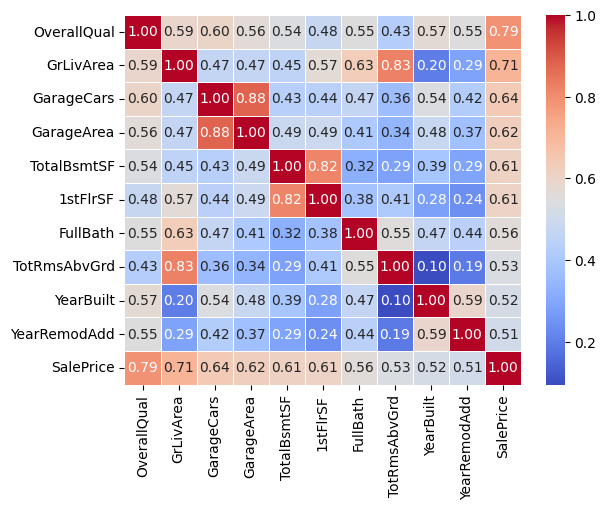

In [ ]:
sns.heatmap(data_train.corr(method='pearson', numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', linewidth=.5)